## Experimento 2: hueco al final de la serie temporal

Cuando tenemos el hueco tan al final que no podemos utilizar el algoritmo base, tenemos dos opciones:
1. Utilizar un algoritmo de series temporales sobre toda la serie (Prophet funciona muy bien y muy rápido)
2. Utilizar el algoritmo base solamente con datos anteriores, es decir, perdemos la información que hay detrás.

Además, podemos también modificar el algoritmo base para, en vez de añadir una semana por cada día de hueco, añadir dos. Esto haría que tuviéramos todavía más datos disponibles, pero puede afectar negativamente en el tiempo de ejecución.

Queremos repetir el experimento del fichero [de experimentos]('../../experimento.ipynb') pero esta vez capturando datos sobre mae y sobre mape. Lo hemos separado para poder ejecutarlo en paralelo:

Tal y como hemos estado observando en otros de los experimentos que hemos hecho, para el algoritmo base estamos considerando tomar tanto dos días por cada día de hueco, como una semana. Volvemos a utilizar el fichero 'site-weather.csv' e introduciremos un hueco de longitud de 1 día a 10 días, tan al final de la serie, que no podamos utilizar el algoritmo base como tal.

In [1]:
# Basic imports
import csv
import numpy as np
import pandas as pd
from pandas import Series
import datetime
import time
import os
import math
import seaborn as sns

path = "../../../data" #Path with raw csv files
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
files = os.listdir(path)
path_postprocess = path + "_postprocess"
#in the cleaning code we insert the rows that are apparently missing

freqs = {'zone_co2.csv':'1min', 'ele.csv': '15min', 'zone_temp_sp_c.csv':'5min', 'occ.csv':'1min', 'zone_temp_exterior.csv':'1min', 'zone_temp_sp_h.csv':'5min', 'site_weather.csv':'15min', 'wifi.csv': '10min', 'zone_temp_interior.csv':'10min'}
starts = {'ele.csv': '2018/1/1 1:00', 'zone_temp_sp_c.csv':'2018/9/15 10:00', 'occ.csv':'2018-05-22 07:00:00', 'zone_temp_exterior.csv':'2018-01-01 00:00:00', 'zone_temp_sp_h.csv':'2018/9/15 10:00', 'site_weather.csv':'2018-01-01 00:00:00', 'wifi.csv': '2018/5/22 00:00', 'zone_temp_interior.csv':'2018-02-22 00:30:00'}
ends = {'ele.csv': '2021/1/1 0:00', 'zone_temp_sp_c.csv':'2021/1/1 0:00', 'occ.csv':'2019-02-21 10:12:00', 'zone_temp_exterior.csv':'2021-01-01 00:00:00', 'zone_temp_sp_h.csv':'2021/1/1 0:00', 'site_weather.csv':'2021-01-01 00:00:00', 'wifi.csv': '2018/7/11 23:50', 'zone_temp_interior.csv':'2021-01-01 00:00:00'}

## Funciones diseñadas:

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [3]:
def interpolate_Prophet(df,i, start_index, end_index):
    m = Prophet()
    s=start_index+1
    e = end_index
    
    df_medio= df.iloc[s:e, i]


    df_prophet = df[df[df.columns[i]].notna()][['date', df.columns[i]]]
    df_medio = df.iloc[s:e, [0, i]]
    df_prophet.columns = ['ds', 'y']
    m.fit(df_prophet)


    future = df_medio[['date']]
    future.columns=['ds']
    forecast_antes = m.predict(future)[['ds', 'yhat']]
    gap = forecast_antes['yhat']
    return gap

In [4]:
def interpolate_ML(df,i, start_df, end_df, start_index, end_index):
    #PASO 1: OBTENER DATOS ANTES Y DESPUÉS



    #print("Gap: \ndf before[", start_df, ':', 'start_index', start_index, ']\ndf after[', end_index, ':', end_df, ']')
    s=start_index+1
    e = end_index


    df_antes = df.iloc[start_df:s, i]
    df_despues= df.iloc[e:end_df, i].loc[::-1]
    df_medio= df.iloc[s:e, i]
    #print("Df_antes: ", df_antes.shape[0], "Df_medio: ", df_medio.shape[0], "Df_despues: ", df_despues.shape[0])

    assert df_medio.shape[0]+df_despues.shape[0]+df_antes.shape[0]==end_df-start_df
    # PASO 2: CREAR DATAFRAMES !!! SI el de después  es menor que el medio (antes siempre tenemos el resto del df), solamente ejecutamos con el de después
    if (df_despues.shape[0]<df_medio.shape[0]):
        print("Solo usamos datos anteriores")
        
        T = df_medio.shape[0]
        a = np.array(df_antes)
        train_antes =np.lib.stride_tricks.sliding_window_view(a, T+1)[:-1]
        test_antes = a[T+1:]

        svr_antes = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
        svr_antes.fit(train_antes, test_antes)

        start = start_index-start_df
        for i in range(T):
            at = a[start-T-1+i:start+i]
            a=np.append(a,svr_antes.predict(at.reshape(1,-1)))
        gap=a[start:start+T]
        
        

    else:
        # Creamos los dataframes
        a = np.array(df_antes)
        b=np.array(df_despues)
        T = df_medio.shape[0]

        train_antes =np.lib.stride_tricks.sliding_window_view(a, T+1)[:-1]
        test_antes = a[T+1:]
        #print("train_antes, ", len(train_antes), "test_antes, ", len(test_antes))
        train_despues = np.lib.stride_tricks.sliding_window_view(b, T+1)[:-1]
        test_despues = b[T+1:]

        # PASO 3: ENTRENAR MODELOS


        svr_antes = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

        svr_antes.fit(train_antes, test_antes)
        svr_despues = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

        svr_despues.fit(train_despues, test_despues)

        # PASO 4: OBTENER PREDICCIONES

        
        start = start_index-start_df
        for i in range(T):
            at = a[start-T-1+i:start+i]
            a=np.append(a,svr_antes.predict(at.reshape(1,-1)))

            dp = b[df_despues.shape[0]-T-1+i:df_despues.shape[0]+i]
            b=np.append(b,svr_despues.predict(dp.reshape(1,-1)))
        
        # PASO 5: COMBINAR
        predictions_antes = a[start:start+T]
        predictions_despues = b[df_despues.shape[0]:df_despues.shape[0]+T]
        gap=(predictions_antes+predictions_despues[::-1])/2
    return gap

In [5]:
def obtain_data(df, i):



    #print("Estamos en: ", i)
    k = 0

    start_index = {}
    starttime = {}
    end_index = {}
    endtime = {}
    tipo = {}

    k2 =0
    start_index_peque = {}
    starttime_peque = {}
    end_index_peque = {}
    endtime_peque = {}


    gap = {}
    start_gap_index =0
    end_gap_index =0
    start_gap_dt=datetime.datetime.strptime(str(df.iloc[0,0]), '%Y-%m-%d %H:%M:%S')
    end_gap_dt = datetime.datetime.strptime(str(df.iloc[0,0]), '%Y-%m-%d %H:%M:%S')
    for j in range(0, len(df.index)):
        

        if (pd.isnull(df.iloc[j,i]) or math.isnan(df.iloc[j,i]))and pd.isnull(df.iloc[j-1,i]) == False:
            start_gap_index = j-1
            start_gap_dt = datetime.datetime.strptime(str(df.iloc[j-1,0]), '%Y-%m-%d %H:%M:%S')
            starttime[k]=df.iloc[j-1,0] #start time of the gap
            start_index[k]=j-1
        elif (pd.isnull(df.iloc[j-1,i]) or math.isnan(df.iloc[j-1,i])) and pd.isnull(df.iloc[j,i]) == False:
            end_gap_index = j
            end_gap_dt=datetime.datetime.strptime(str(df.iloc[end_gap_index,0]), '%Y-%m-%d %H:%M:%S')
            if (abs(end_gap_dt-start_gap_dt).total_seconds()<3600):
                start_index_peque[k2] = start_gap_index
                end_index_peque[k2]=end_gap_index
                starttime_peque[k2]= df.iloc[start_gap_index,0]
                endtime_peque[k2]= df.iloc[end_gap_index,0]
                k2=k2+1
            else:
                start_index[k] = start_gap_index
                end_index[k]=end_gap_index
                starttime[k]= df.iloc[start_gap_index,0]
                endtime[k]= df.iloc[end_gap_index,0]
                tipo[k] = abs((end_gap_dt-start_gap_dt).days)+1
                
                k=k+1
    return [(start_index, end_index,tipo ), (start_index_peque, end_index_peque)]
    



In [6]:
def fill_small_gaps(df, start_index_peque, end_index_peque, i):
    k2 = len(start_index_peque)
    if k2!=0:
        for m in range(k2): 
            df.iloc[start_index_peque[m]:end_index_peque[m]+1,i]=df.iloc[start_index_peque[m]:end_index_peque[m]+1,i].interpolate(method='linear')

In [7]:
def mix_big_gaps(start_index, end_index, tipo, freq=4):
    k = len(start_index)
    gaps = {}
    days_interpolation ={}
    t =0
    m =0
    if k!=0:
        while (m<k):
            #print("Estoy en: ", m)
            gap = m
            next_gap = m+1 
            start = start_index[m]
            end_index_t = end_index[m]
            current_gap = [[start_index[m], end_index[m], 0, end_index[m]-start_index[m]]]
            type = tipo[m]
            T = abs(end_index[m]-start_index[m])
            
            while (next_gap<k and abs(end_index_t-start_index[next_gap])<T ):
                #print("Fusión en: ", gap, "con ", next_gap)
                #print("T: ", abs(end_index_t-start))
                m= m+1
                local_index = current_gap[-1][3]+(start_index[next_gap]-end_index_t)
                #Si está muy cerca se lo metemos al current_gap
                current_gap.append([start_index[next_gap], end_index[next_gap], local_index,local_index+(end_index[next_gap]-start_index[next_gap])])
                
                type = type + tipo[m]
                end_index_t = end_index[next_gap]
                next_gap= next_gap +1
                T = abs(end_index_t-start)
                
            m = m+1
            gaps[t]=current_gap
            days_interpolation[t]=type
            t=t+1   
        return (gaps, days_interpolation)


In [8]:
def fill_big_gaps(df, gaps, days_interpolation, i, freq=4):
    k = len(gaps)
    if k!=0:
        for m in range(k):
            
            days = days_interpolation[m]
            start_i = gaps[m][0][0]
            end_i = gaps[m][-1][1]
            #print("We are in gap: ", m, "\nMixed gaps: ", gaps[m])
            #print("Gap of " , days, 'days')

            end_gap_anterior = (gaps[m-1][-1][1])if m>0 else 0
            start_gap_siguiente = (gaps[m+1][0][0])if m+1!=k else len(df.index)
            # Si el anterior ha acabado hace más de una semana, nos quedamos con el que se hace una semana justa

            start_df = start_i-(days*7*freq*24) if (start_i-days*7*freq*24>=0 ) else 0
            
            
            # Si el sigueinte empieza más tarde de una semana, nos quedamos con la semana siguiente solamente
            end_df = end_i+(days*7*freq*24) if (start_gap_siguiente-end_i > days*7*freq*24 ) else start_gap_siguiente
            results = interpolate_ML(df,i, start_df, end_df, start_i, end_i)
            pos =0
            for independent_gap in gaps[m]:
                
                df.iloc[independent_gap[0]+1:independent_gap[1],i]=results[independent_gap[2]:independent_gap[3]-1]
            
                
        
        

In [9]:
def clean_df_var(df, i, show=False):
    copia = df[['date', df.columns[i]]].copy()
    data = obtain_data(df, i)
    start_index, end_index,tipo = data[0]
    start_index_peque, end_index_peque=data[1]
    fill_small_gaps(df, start_index_peque, end_index_peque, i)
    gaps, days_interpolation = mix_big_gaps(start_index, end_index, tipo)
    fill_big_gaps(df, gaps, days_interpolation, i)
    print("Finished: ", df.columns[i])
    if(show):
        fig = make_subplots(rows=2, cols=1,  shared_xaxes=True, subplot_titles=("Bruto",  "Final") )


        fig.add_trace(
            go.Scatter(x=copia.date , y=copia[df.columns[i]]),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(x=df.date , y=df[df.columns[i]]),
            row=2, col=1
        )



        fig.update_layout(legend_orientation="h", 
                    xaxis2_rangeslider_visible=True, xaxis2_rangeslider_thickness=0.1, height=600, width=800, title_text="Mels_S" )
        fig.show()


## Ejecución del experimento

In [11]:
file = 'site_weather.csv'
df = pd.read_csv(path+'/'+file)
path_2 = '../data_postprocess/data_done'
print(path+'/'+file)
start = starts[file]
end = ends[file]
freq = freqs[file]
df['date'] = pd.to_datetime(df['date']) 
df =df[(df.date>=start)&(df.date<=end)]
helper=pd.DataFrame({'date': pd.date_range(start, end, freq=freq)})
df = pd.merge(df, helper, on='date', how='outer').sort_values('date')

df.sort_values(by='date', inplace=True)
df = df[df.date <= '2020-03-01']

df.head()
var='air_temp_set_1'

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df.date , y=df[var])
)
fig.update_layout(legend_orientation="v", 
             xaxis_rangeslider_visible=True, xaxis_rangeslider_thickness=0.1, height=600, width=1000 )
fig.show()
#  Vamos a probar haciendo downsampling a 15 minutos


../../../data/site_weather.csv


In [12]:
df = df[['date', var]]
copia = df.copy()
copia.set_index('date', inplace=True)

In [13]:
def experimento_finaldf(iteraciones, longitud, copia, freq=4):
    tiempos =[[],[],[]]
    mse =[[], [],[]]
    mae =[[], [],[]]
    mape =[[], [],[]]
    for j in range(iteraciones):

        print("\nINFORMACIÓN ITERACIÓN ", j)
        df = copia.copy()
        df.reset_index(inplace=True)
        
        
        index_inicial = df.shape[0]-2*longitud + random.randint(1, longitud-1)
        #print("Índice inicial: ", index_inicial)
        #Insertamos valores nulos
        df.iloc[index_inicial:index_inicial+longitud, 1] = np.nan
        
        df1 = df.copy()
        
        index_final = index_inicial+longitud

        #Obtenemos la información sobre los huecos
        data = obtain_data(df, 1)
        start_index, end_index,tipo = data[0]
        start_index_peque, end_index_peque=data[1]
        fill_small_gaps(df, start_index_peque, end_index_peque, 1)
        gaps, days_interpolation = mix_big_gaps(start_index, end_index, tipo)


        m=0
        k = len(gaps)
        freq =4

        days = days_interpolation[m]
        start_i = gaps[m][0][0]
        end_i = gaps[m][-1][1]
        
        #Interpolamos con Prophet

        inicio = time.time()
        results = interpolate_Prophet(df,1, start_i, end_i)
        fin=time.time()
        tiempos[0].append(fin-inicio)
        mse[0].append(mean_squared_error(copia.iloc[start_i+1:end_i, 0], results))
        mae[0].append(mean_absolute_error(copia.iloc[start_i+1:end_i, 0], results))
        mape[0].append(mean_absolute_percentage_error(copia.iloc[start_i+1:end_i, 0], results))
        print("Tiempo Prophet: ", fin-inicio)


        #Interpolamos con ML
        end_gap_anterior = (gaps[m-1][-1][1])if m>0 else 0
        start_gap_siguiente = (gaps[m+1][0][0])if m+1!=k else len(df1.index)

        # 2 días de información
        start_df = start_i-(days*2*freq*24) if (start_i-days*2*freq*24>=0 ) else 0
        end_df = end_i+(days*2*freq*24) if (start_gap_siguiente-end_i > days*2*freq*24 ) else start_gap_siguiente
        inicio=time.time()
        results1 = interpolate_ML(df1,1, start_df, end_df, start_i, end_i)
        fin=time.time()
        tiempos[1].append(fin-inicio)
        mse[1].append(mean_squared_error(copia.iloc[start_i+1:end_i, 0], results1))
        mae[1].append(mean_absolute_error(copia.iloc[start_i+1:end_i, 0], results1))
        mape[1].append(mean_absolute_percentage_error(copia.iloc[start_i+1:end_i, 0], results1))
        print("Tiempo SVR dos días: ", fin-inicio)


        # 7 días de información
        start_df = start_i-(days*7*freq*24) if (start_i-days*7*freq*24>=0 ) else 0
        end_df = end_i+(days*7*freq*24) if (start_gap_siguiente-end_i > days*7*freq*24 ) else start_gap_siguiente
        inicio=time.time()
        results1 = interpolate_ML(df1,1, start_df, end_df, start_i, end_i)
        fin=time.time()
        tiempos[2].append(fin-inicio)
        mse[2].append(mean_squared_error(copia.iloc[start_i+1:end_i, 0], results1))
        mae[2].append(mean_absolute_error(copia.iloc[start_i+1:end_i, 0], results1))
        mape[2].append(mean_absolute_percentage_error(copia.iloc[start_i+1:end_i, 0], results1))
        print("Tiempo SVR siete días: ", fin-inicio)
        
    return tiempos, mse, mae, mape

In [24]:
times =[]
mse_total =[]
mae_total =[]
mape_total =[]

for longitud in range(1,11):
    data = experimento_finaldf(20, longitud*4*24, copia)
    times.append(data[0])
    mse_total.append(data[1])
    mae_total.append(data[2])
    mape_total.append(data[3])
    
    print("\n===============RESUMEN LONGITUD ", longitud, "=======================================")
    print('MSE Prophet',np.array(data[1][0]).mean())
    print('MSE 2',np.array(data[1][1]).mean())
    print('MSE 7',np.array(data[1][2]).mean())

    print("\n=====================================================================================")




INFORMACIÓN ITERACIÓN  0


16:03:00 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  63.0215368270874
Solo usamos datos anteriores
Tiempo SVR dos días:  0.021374940872192383
Solo usamos datos anteriores
Tiempo SVR siete días:  0.1390819549560547

INFORMACIÓN ITERACIÓN  1


16:04:08 - cmdstanpy - INFO - Chain [1] start processing
16:04:58 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.728399991989136
Solo usamos datos anteriores
Tiempo SVR dos días:  0.023221969604492188
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3048110008239746

INFORMACIÓN ITERACIÓN  2


16:05:10 - cmdstanpy - INFO - Chain [1] start processing
16:06:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.110304832458496
Solo usamos datos anteriores
Tiempo SVR dos días:  0.0263822078704834
Solo usamos datos anteriores
Tiempo SVR siete días:  0.147963285446167

INFORMACIÓN ITERACIÓN  3


16:06:13 - cmdstanpy - INFO - Chain [1] start processing
16:07:13 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  64.85648274421692
Solo usamos datos anteriores
Tiempo SVR dos días:  0.020607948303222656
Solo usamos datos anteriores
Tiempo SVR siete días:  0.12096786499023438

INFORMACIÓN ITERACIÓN  4


16:07:23 - cmdstanpy - INFO - Chain [1] start processing
16:08:14 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  56.42014813423157
Solo usamos datos anteriores
Tiempo SVR dos días:  0.017349958419799805
Solo usamos datos anteriores
Tiempo SVR siete días:  0.12561392784118652

INFORMACIÓN ITERACIÓN  5


16:08:24 - cmdstanpy - INFO - Chain [1] start processing
16:09:33 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  73.64797616004944
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03354501724243164
Solo usamos datos anteriores
Tiempo SVR siete días:  0.1329030990600586

INFORMACIÓN ITERACIÓN  6


16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:10:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  71.38622713088989
Solo usamos datos anteriores
Tiempo SVR dos días:  0.02166581153869629
Solo usamos datos anteriores
Tiempo SVR siete días:  0.1381988525390625

INFORMACIÓN ITERACIÓN  7


16:11:00 - cmdstanpy - INFO - Chain [1] start processing
16:11:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  63.88178992271423
Solo usamos datos anteriores
Tiempo SVR dos días:  0.02481985092163086
Solo usamos datos anteriores
Tiempo SVR siete días:  0.13923931121826172

INFORMACIÓN ITERACIÓN  8


16:12:10 - cmdstanpy - INFO - Chain [1] start processing
16:13:13 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  68.19465780258179
Solo usamos datos anteriores
Tiempo SVR dos días:  0.01766204833984375
Solo usamos datos anteriores
Tiempo SVR siete días:  0.11677289009094238

INFORMACIÓN ITERACIÓN  9


16:13:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  78.24223399162292
Solo usamos datos anteriores
Tiempo SVR dos días:  0.018686771392822266
Solo usamos datos anteriores
Tiempo SVR siete días:  0.1220557689666748

INFORMACIÓN ITERACIÓN  10


16:14:46 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  74.26821398735046
Solo usamos datos anteriores
Tiempo SVR dos días:  0.02403092384338379
Solo usamos datos anteriores
Tiempo SVR siete días:  0.16145730018615723

INFORMACIÓN ITERACIÓN  11


16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:03 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.51424527168274
Solo usamos datos anteriores
Tiempo SVR dos días:  0.02070331573486328
Solo usamos datos anteriores
Tiempo SVR siete días:  0.1401972770690918

INFORMACIÓN ITERACIÓN  12


16:17:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  58.947060108184814
Solo usamos datos anteriores
Tiempo SVR dos días:  0.019063949584960938
Solo usamos datos anteriores
Tiempo SVR siete días:  0.11934423446655273

INFORMACIÓN ITERACIÓN  13


16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  81.6133508682251
Solo usamos datos anteriores
Tiempo SVR dos días:  0.01864790916442871
Solo usamos datos anteriores
Tiempo SVR siete días:  0.12221693992614746

INFORMACIÓN ITERACIÓN  14


16:19:45 - cmdstanpy - INFO - Chain [1] start processing
16:20:48 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  68.91228175163269
Solo usamos datos anteriores
Tiempo SVR dos días:  0.022450923919677734
Solo usamos datos anteriores
Tiempo SVR siete días:  0.13704609870910645

INFORMACIÓN ITERACIÓN  15


16:20:59 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  82.886714220047
Solo usamos datos anteriores
Tiempo SVR dos días:  0.018908023834228516
Solo usamos datos anteriores
Tiempo SVR siete días:  0.12183880805969238

INFORMACIÓN ITERACIÓN  16


16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.85450315475464
Solo usamos datos anteriores
Tiempo SVR dos días:  0.018123626708984375
Solo usamos datos anteriores
Tiempo SVR siete días:  0.12296199798583984

INFORMACIÓN ITERACIÓN  17


16:23:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  72.60449981689453
Solo usamos datos anteriores
Tiempo SVR dos días:  0.022349119186401367
Solo usamos datos anteriores
Tiempo SVR siete días:  0.14992785453796387

INFORMACIÓN ITERACIÓN  18


16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  64.89519906044006
Solo usamos datos anteriores
Tiempo SVR dos días:  0.023543834686279297
Solo usamos datos anteriores
Tiempo SVR siete días:  0.1396019458770752

INFORMACIÓN ITERACIÓN  19


16:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.39968705177307
Solo usamos datos anteriores
Tiempo SVR dos días:  0.020615816116333008
Solo usamos datos anteriores
Tiempo SVR siete días:  0.13972210884094238

===============RESUMEN LONGITUD  1 =======================================
MSE Prophet 13.468390394554717
MSE 2 27.172332950168247
MSE 7 40.50293248848016


INFORMACIÓN ITERACIÓN  0


16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:28:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  73.79426002502441
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03276705741882324
Solo usamos datos anteriores
Tiempo SVR siete días:  0.28136706352233887

INFORMACIÓN ITERACIÓN  1


16:28:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:15 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  68.50017809867859
Solo usamos datos anteriores
Tiempo SVR dos días:  0.04380607604980469
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3592190742492676

INFORMACIÓN ITERACIÓN  2


16:29:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  76.26444888114929
Solo usamos datos anteriores
Tiempo SVR dos días:  0.0393829345703125
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3378469944000244

INFORMACIÓN ITERACIÓN  3


16:30:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  76.8173758983612
Solo usamos datos anteriores
Tiempo SVR dos días:  0.039808034896850586
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3257100582122803

INFORMACIÓN ITERACIÓN  4


16:32:10 - cmdstanpy - INFO - Chain [1] start processing
16:33:19 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  74.36643314361572
Solo usamos datos anteriores
Tiempo SVR dos días:  0.038286685943603516
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3158581256866455

INFORMACIÓN ITERACIÓN  5


16:33:30 - cmdstanpy - INFO - Chain [1] start processing
16:34:08 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.41189384460449
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03737497329711914
Solo usamos datos anteriores
Tiempo SVR siete días:  0.2993760108947754

INFORMACIÓN ITERACIÓN  6


16:34:18 - cmdstanpy - INFO - Chain [1] start processing
16:35:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  66.59017300605774
Solo usamos datos anteriores
Tiempo SVR dos días:  0.032363176345825195
Solo usamos datos anteriores
Tiempo SVR siete días:  0.2678499221801758

INFORMACIÓN ITERACIÓN  7


16:35:30 - cmdstanpy - INFO - Chain [1] start processing
16:36:28 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  62.816174030303955
Solo usamos datos anteriores
Tiempo SVR dos días:  0.033967018127441406
Solo usamos datos anteriores
Tiempo SVR siete días:  0.30832505226135254

INFORMACIÓN ITERACIÓN  8


16:36:38 - cmdstanpy - INFO - Chain [1] start processing
16:37:33 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  59.99574589729309
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03350186347961426
Solo usamos datos anteriores
Tiempo SVR siete días:  0.26994919776916504

INFORMACIÓN ITERACIÓN  9


16:37:42 - cmdstanpy - INFO - Chain [1] start processing
16:38:30 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.45341515541077
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03536367416381836
Solo usamos datos anteriores
Tiempo SVR siete días:  0.29924917221069336

INFORMACIÓN ITERACIÓN  10


16:38:40 - cmdstanpy - INFO - Chain [1] start processing
16:39:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  40.55033493041992
Solo usamos datos anteriores
Tiempo SVR dos días:  0.038210153579711914
Solo usamos datos anteriores
Tiempo SVR siete días:  0.2991461753845215

INFORMACIÓN ITERACIÓN  11


16:39:27 - cmdstanpy - INFO - Chain [1] start processing
16:40:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.813042879104614
Solo usamos datos anteriores
Tiempo SVR dos días:  0.04405093193054199
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3188920021057129

INFORMACIÓN ITERACIÓN  12


16:40:12 - cmdstanpy - INFO - Chain [1] start processing
16:41:12 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  65.32255816459656
Solo usamos datos anteriores
Tiempo SVR dos días:  0.0320589542388916
Solo usamos datos anteriores
Tiempo SVR siete días:  0.2661459445953369

INFORMACIÓN ITERACIÓN  13


16:41:22 - cmdstanpy - INFO - Chain [1] start processing
16:41:56 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.304075956344604
Solo usamos datos anteriores
Tiempo SVR dos días:  0.050598859786987305
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3649630546569824

INFORMACIÓN ITERACIÓN  14


16:42:07 - cmdstanpy - INFO - Chain [1] start processing
16:42:58 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.96912479400635
Solo usamos datos anteriores
Tiempo SVR dos días:  0.0391848087310791
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3326408863067627

INFORMACIÓN ITERACIÓN  15


16:43:08 - cmdstanpy - INFO - Chain [1] start processing
16:44:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.591509103775024
Solo usamos datos anteriores
Tiempo SVR dos días:  0.036132097244262695
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3004758358001709

INFORMACIÓN ITERACIÓN  16


16:44:11 - cmdstanpy - INFO - Chain [1] start processing
16:45:13 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  67.18251013755798
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03559708595275879
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3024158477783203

INFORMACIÓN ITERACIÓN  17


16:45:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:25 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  66.10517001152039
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03243899345397949
Solo usamos datos anteriores
Tiempo SVR siete días:  0.262188196182251

INFORMACIÓN ITERACIÓN  18


16:46:34 - cmdstanpy - INFO - Chain [1] start processing
16:47:34 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  64.34348678588867
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03864097595214844
Solo usamos datos anteriores
Tiempo SVR siete días:  0.31774282455444336

INFORMACIÓN ITERACIÓN  19


16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:48:47 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  67.97400498390198
Solo usamos datos anteriores
Tiempo SVR dos días:  0.03722810745239258
Solo usamos datos anteriores
Tiempo SVR siete días:  0.3120729923248291

===============RESUMEN LONGITUD  2 =======================================
MSE Prophet 30.90104142825435
MSE 2 24.57549316617335
MSE 7 45.50731090639288


INFORMACIÓN ITERACIÓN  0


16:48:57 - cmdstanpy - INFO - Chain [1] start processing
16:49:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.244004011154175
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06023812294006348
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6207890510559082

INFORMACIÓN ITERACIÓN  1


16:49:51 - cmdstanpy - INFO - Chain [1] start processing
16:51:15 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  88.3471167087555
Solo usamos datos anteriores
Tiempo SVR dos días:  0.0727691650390625
Solo usamos datos anteriores
Tiempo SVR siete días:  0.658416748046875

INFORMACIÓN ITERACIÓN  2


16:51:25 - cmdstanpy - INFO - Chain [1] start processing
16:51:55 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.55499076843262
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06191587448120117
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6367881298065186

INFORMACIÓN ITERACIÓN  3


16:52:06 - cmdstanpy - INFO - Chain [1] start processing
16:52:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.57355618476868
Solo usamos datos anteriores
Tiempo SVR dos días:  0.0713343620300293
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6185991764068604

INFORMACIÓN ITERACIÓN  4


16:53:00 - cmdstanpy - INFO - Chain [1] start processing
16:54:00 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  65.14128994941711
Solo usamos datos anteriores
Tiempo SVR dos días:  0.07217192649841309
Solo usamos datos anteriores
Tiempo SVR siete días:  0.683150053024292

INFORMACIÓN ITERACIÓN  5


16:54:10 - cmdstanpy - INFO - Chain [1] start processing
16:55:04 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  58.40175676345825
Solo usamos datos anteriores
Tiempo SVR dos días:  0.0614628791809082
Solo usamos datos anteriores
Tiempo SVR siete días:  0.5923240184783936

INFORMACIÓN ITERACIÓN  6


16:55:13 - cmdstanpy - INFO - Chain [1] start processing
16:55:56 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.103394746780396
Solo usamos datos anteriores
Tiempo SVR dos días:  0.061934709548950195
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6660261154174805

INFORMACIÓN ITERACIÓN  7


16:56:06 - cmdstanpy - INFO - Chain [1] start processing
16:56:51 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.15864181518555
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06367278099060059
Solo usamos datos anteriores
Tiempo SVR siete días:  0.715386152267456

INFORMACIÓN ITERACIÓN  8


16:57:01 - cmdstanpy - INFO - Chain [1] start processing
16:57:52 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.40914011001587
Solo usamos datos anteriores
Tiempo SVR dos días:  0.08269786834716797
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6915369033813477

INFORMACIÓN ITERACIÓN  9


16:58:03 - cmdstanpy - INFO - Chain [1] start processing
16:58:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.49904990196228
Solo usamos datos anteriores
Tiempo SVR dos días:  0.11023473739624023
Solo usamos datos anteriores
Tiempo SVR siete días:  0.678804874420166

INFORMACIÓN ITERACIÓN  10


16:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:00:06 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  60.85376214981079
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06208467483520508
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6199290752410889

INFORMACIÓN ITERACIÓN  11


17:00:16 - cmdstanpy - INFO - Chain [1] start processing
17:00:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  25.519953727722168
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06467127799987793
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6112141609191895

INFORMACIÓN ITERACIÓN  12


17:00:46 - cmdstanpy - INFO - Chain [1] start processing
17:01:48 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  66.2109522819519
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06157398223876953
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6308069229125977

INFORMACIÓN ITERACIÓN  13


17:01:58 - cmdstanpy - INFO - Chain [1] start processing
17:02:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.880171060562134
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06244516372680664
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6147761344909668

INFORMACIÓN ITERACIÓN  14


17:02:55 - cmdstanpy - INFO - Chain [1] start processing
17:03:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.39174509048462
Solo usamos datos anteriores
Tiempo SVR dos días:  0.05730009078979492
Solo usamos datos anteriores
Tiempo SVR siete días:  0.5184218883514404

INFORMACIÓN ITERACIÓN  15


17:03:47 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  53.547314167022705
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06810998916625977
Solo usamos datos anteriores
Tiempo SVR siete días:  0.598484992980957

INFORMACIÓN ITERACIÓN  16


17:04:46 - cmdstanpy - INFO - Chain [1] start processing
17:05:39 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.94169783592224
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06676769256591797
Solo usamos datos anteriores
Tiempo SVR siete días:  0.621840238571167

INFORMACIÓN ITERACIÓN  17


17:05:49 - cmdstanpy - INFO - Chain [1] start processing
17:06:40 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.21880030632019
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06393599510192871
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6779830455780029

INFORMACIÓN ITERACIÓN  18


17:06:50 - cmdstanpy - INFO - Chain [1] start processing
17:07:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.25374722480774
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06298208236694336
Solo usamos datos anteriores
Tiempo SVR siete días:  0.6245548725128174

INFORMACIÓN ITERACIÓN  19


17:07:46 - cmdstanpy - INFO - Chain [1] start processing
17:08:11 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  29.950949907302856
Solo usamos datos anteriores
Tiempo SVR dos días:  0.06369900703430176
Solo usamos datos anteriores
Tiempo SVR siete días:  0.673865795135498

===============RESUMEN LONGITUD  3 =======================================
MSE Prophet 36.48694588065555
MSE 2 35.13323469622182
MSE 7 40.66160214058044


INFORMACIÓN ITERACIÓN  0


17:08:22 - cmdstanpy - INFO - Chain [1] start processing
17:08:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  29.038037061691284
Solo usamos datos anteriores
Tiempo SVR dos días:  0.09409093856811523
Solo usamos datos anteriores
Tiempo SVR siete días:  0.9218919277191162

INFORMACIÓN ITERACIÓN  1


17:08:57 - cmdstanpy - INFO - Chain [1] start processing
17:09:30 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.80516290664673
Solo usamos datos anteriores
Tiempo SVR dos días:  0.12818479537963867
Solo usamos datos anteriores
Tiempo SVR siete días:  1.1581721305847168

INFORMACIÓN ITERACIÓN  2


17:09:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:14 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  37.48845291137695
Solo usamos datos anteriores
Tiempo SVR dos días:  0.12036609649658203
Solo usamos datos anteriores
Tiempo SVR siete días:  1.0379679203033447

INFORMACIÓN ITERACIÓN  3


17:10:25 - cmdstanpy - INFO - Chain [1] start processing
17:11:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  59.73711705207825
Solo usamos datos anteriores
Tiempo SVR dos días:  0.10671210289001465
Solo usamos datos anteriores
Tiempo SVR siete días:  1.1442608833312988

INFORMACIÓN ITERACIÓN  4


17:11:31 - cmdstanpy - INFO - Chain [1] start processing
17:12:11 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.168673038482666
Solo usamos datos anteriores
Tiempo SVR dos días:  0.15263795852661133
Solo usamos datos anteriores
Tiempo SVR siete días:  1.1841809749603271

INFORMACIÓN ITERACIÓN  5


17:12:23 - cmdstanpy - INFO - Chain [1] start processing
17:13:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.858938217163086
Solo usamos datos anteriores
Tiempo SVR dos días:  0.1113121509552002
Solo usamos datos anteriores
Tiempo SVR siete días:  1.0367119312286377

INFORMACIÓN ITERACIÓN  6


17:13:26 - cmdstanpy - INFO - Chain [1] start processing
17:14:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.447224855422974
Solo usamos datos anteriores
Tiempo SVR dos días:  0.1066749095916748
Solo usamos datos anteriores
Tiempo SVR siete días:  1.0865890979766846

INFORMACIÓN ITERACIÓN  7


17:14:28 - cmdstanpy - INFO - Chain [1] start processing
17:15:30 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  67.08060097694397
Solo usamos datos anteriores
Tiempo SVR dos días:  0.10691499710083008
Solo usamos datos anteriores
Tiempo SVR siete días:  1.065946102142334

INFORMACIÓN ITERACIÓN  8


17:15:40 - cmdstanpy - INFO - Chain [1] start processing
17:16:26 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.98062515258789
Solo usamos datos anteriores
Tiempo SVR dos días:  0.10723090171813965
Solo usamos datos anteriores
Tiempo SVR siete días:  1.106015920639038

INFORMACIÓN ITERACIÓN  9


17:16:36 - cmdstanpy - INFO - Chain [1] start processing
17:17:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  74.34540820121765
Solo usamos datos anteriores
Tiempo SVR dos días:  0.11016225814819336
Solo usamos datos anteriores
Tiempo SVR siete días:  1.1164710521697998

INFORMACIÓN ITERACIÓN  10


17:17:58 - cmdstanpy - INFO - Chain [1] start processing
17:18:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.78501510620117
Solo usamos datos anteriores
Tiempo SVR dos días:  0.11145591735839844
Solo usamos datos anteriores
Tiempo SVR siete días:  1.0670421123504639

INFORMACIÓN ITERACIÓN  11


17:18:47 - cmdstanpy - INFO - Chain [1] start processing
17:19:31 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.32774806022644
Solo usamos datos anteriores
Tiempo SVR dos días:  0.11060881614685059
Solo usamos datos anteriores
Tiempo SVR siete días:  1.084045171737671

INFORMACIÓN ITERACIÓN  12


17:19:42 - cmdstanpy - INFO - Chain [1] start processing
17:20:15 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  37.99486780166626
Solo usamos datos anteriores
Tiempo SVR dos días:  0.12268996238708496
Solo usamos datos anteriores
Tiempo SVR siete días:  1.1122443675994873

INFORMACIÓN ITERACIÓN  13


17:20:26 - cmdstanpy - INFO - Chain [1] start processing
17:20:56 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.63651204109192
Solo usamos datos anteriores
Tiempo SVR dos días:  0.10868287086486816
Solo usamos datos anteriores
Tiempo SVR siete días:  1.1242070198059082

INFORMACIÓN ITERACIÓN  14


17:21:07 - cmdstanpy - INFO - Chain [1] start processing
17:22:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  58.58881902694702
Solo usamos datos anteriores
Tiempo SVR dos días:  0.09433913230895996
Solo usamos datos anteriores
Tiempo SVR siete días:  0.9948458671569824

INFORMACIÓN ITERACIÓN  15


17:22:11 - cmdstanpy - INFO - Chain [1] start processing
17:23:14 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  67.11560416221619
Solo usamos datos anteriores
Tiempo SVR dos días:  0.12305593490600586
Solo usamos datos anteriores
Tiempo SVR siete días:  1.1123549938201904

INFORMACIÓN ITERACIÓN  16


17:23:25 - cmdstanpy - INFO - Chain [1] start processing
17:24:00 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  40.326555013656616
Solo usamos datos anteriores
Tiempo SVR dos días:  0.0903167724609375
Solo usamos datos anteriores
Tiempo SVR siete días:  0.9838471412658691

INFORMACIÓN ITERACIÓN  17


17:24:11 - cmdstanpy - INFO - Chain [1] start processing
17:24:48 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.091986894607544
Solo usamos datos anteriores
Tiempo SVR dos días:  0.11406803131103516
Solo usamos datos anteriores
Tiempo SVR siete días:  1.1176886558532715

INFORMACIÓN ITERACIÓN  18


17:24:59 - cmdstanpy - INFO - Chain [1] start processing
17:25:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.9884877204895
Solo usamos datos anteriores
Tiempo SVR dos días:  0.09367489814758301
Solo usamos datos anteriores
Tiempo SVR siete días:  1.004990816116333

INFORMACIÓN ITERACIÓN  19


17:25:56 - cmdstanpy - INFO - Chain [1] start processing
17:26:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  54.071932315826416
Solo usamos datos anteriores
Tiempo SVR dos días:  0.11434507369995117
Solo usamos datos anteriores
Tiempo SVR siete días:  1.0900254249572754

===============RESUMEN LONGITUD  4 =======================================
MSE Prophet 33.89015804518798
MSE 2 26.545092072280813
MSE 7 35.247870349439985


INFORMACIÓN ITERACIÓN  0


17:26:57 - cmdstanpy - INFO - Chain [1] start processing
17:27:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.1409478187561
Solo usamos datos anteriores
Tiempo SVR dos días:  0.14234614372253418
Solo usamos datos anteriores
Tiempo SVR siete días:  1.4898648262023926

INFORMACIÓN ITERACIÓN  1


17:27:53 - cmdstanpy - INFO - Chain [1] start processing
17:28:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  53.47440004348755
Solo usamos datos anteriores
Tiempo SVR dos días:  0.18105506896972656
Solo usamos datos anteriores
Tiempo SVR siete días:  1.6052472591400146

INFORMACIÓN ITERACIÓN  2


17:28:54 - cmdstanpy - INFO - Chain [1] start processing
17:29:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.00438094139099
Solo usamos datos anteriores
Tiempo SVR dos días:  0.14566802978515625
Solo usamos datos anteriores
Tiempo SVR siete días:  1.4926247596740723

INFORMACIÓN ITERACIÓN  3


17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:39 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.45425081253052
Solo usamos datos anteriores
Tiempo SVR dos días:  0.20390105247497559
Solo usamos datos anteriores
Tiempo SVR siete días:  1.7306809425354004

INFORMACIÓN ITERACIÓN  4


17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.179704904556274
Solo usamos datos anteriores
Tiempo SVR dos días:  0.17359399795532227
Solo usamos datos anteriores
Tiempo SVR siete días:  1.742497205734253

INFORMACIÓN ITERACIÓN  5


17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.61910104751587
Solo usamos datos anteriores
Tiempo SVR dos días:  0.18876385688781738
Solo usamos datos anteriores
Tiempo SVR siete días:  1.6859650611877441

INFORMACIÓN ITERACIÓN  6


17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.07703995704651
Solo usamos datos anteriores
Tiempo SVR dos días:  0.13161587715148926
Solo usamos datos anteriores
Tiempo SVR siete días:  1.4434950351715088

INFORMACIÓN ITERACIÓN  7


17:33:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  66.70081615447998
Solo usamos datos anteriores
Tiempo SVR dos días:  0.15938830375671387
Solo usamos datos anteriores
Tiempo SVR siete días:  1.5634019374847412

INFORMACIÓN ITERACIÓN  8


17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:35:07 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.12764286994934
Solo usamos datos anteriores
Tiempo SVR dos días:  0.16023898124694824
Solo usamos datos anteriores
Tiempo SVR siete días:  1.6988699436187744

INFORMACIÓN ITERACIÓN  9


17:35:19 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.17523694038391
Solo usamos datos anteriores
Tiempo SVR dos días:  0.194810152053833
Solo usamos datos anteriores
Tiempo SVR siete días:  1.652696132659912

INFORMACIÓN ITERACIÓN  10


17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:55 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.54490303993225
Solo usamos datos anteriores
Tiempo SVR dos días:  0.18139386177062988
Solo usamos datos anteriores
Tiempo SVR siete días:  1.7477900981903076

INFORMACIÓN ITERACIÓN  11


17:37:07 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.94594693183899
Solo usamos datos anteriores
Tiempo SVR dos días:  0.17828798294067383
Solo usamos datos anteriores
Tiempo SVR siete días:  1.7856459617614746

INFORMACIÓN ITERACIÓN  12


17:38:16 - cmdstanpy - INFO - Chain [1] start processing
17:38:55 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.91496205329895
Solo usamos datos anteriores
Tiempo SVR dos días:  0.18211030960083008
Solo usamos datos anteriores
Tiempo SVR siete días:  1.762864112854004

INFORMACIÓN ITERACIÓN  13


17:39:07 - cmdstanpy - INFO - Chain [1] start processing
17:39:47 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.956271171569824
Solo usamos datos anteriores
Tiempo SVR dos días:  0.19008421897888184
Solo usamos datos anteriores
Tiempo SVR siete días:  1.6681420803070068

INFORMACIÓN ITERACIÓN  14


17:39:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.83821225166321
Solo usamos datos anteriores
Tiempo SVR dos días:  0.14394903182983398
Solo usamos datos anteriores
Tiempo SVR siete días:  1.4631397724151611

INFORMACIÓN ITERACIÓN  15


17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.679917097091675
Solo usamos datos anteriores
Tiempo SVR dos días:  0.14954805374145508
Solo usamos datos anteriores
Tiempo SVR siete días:  1.5516471862792969

INFORMACIÓN ITERACIÓN  16


17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:33 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.559239864349365
Solo usamos datos anteriores
Tiempo SVR dos días:  0.20644712448120117
Solo usamos datos anteriores
Tiempo SVR siete días:  1.8219578266143799

INFORMACIÓN ITERACIÓN  17


17:42:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:38 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.60340404510498
Solo usamos datos anteriores
Tiempo SVR dos días:  0.17226409912109375
Solo usamos datos anteriores
Tiempo SVR siete días:  1.7177338600158691

INFORMACIÓN ITERACIÓN  18


17:43:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  64.00785422325134
Solo usamos datos anteriores
Tiempo SVR dos días:  0.18607783317565918
Solo usamos datos anteriores
Tiempo SVR siete días:  1.67293381690979

INFORMACIÓN ITERACIÓN  19


17:45:01 - cmdstanpy - INFO - Chain [1] start processing
17:45:38 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  41.6845440864563
Solo usamos datos anteriores
Tiempo SVR dos días:  0.1689291000366211
Solo usamos datos anteriores
Tiempo SVR siete días:  1.7153050899505615

===============RESUMEN LONGITUD  5 =======================================
MSE Prophet 20.69895025262334
MSE 2 19.677981216640568
MSE 7 24.546414703200092


INFORMACIÓN ITERACIÓN  0


17:45:50 - cmdstanpy - INFO - Chain [1] start processing
17:46:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  58.41640496253967
Solo usamos datos anteriores
Tiempo SVR dos días:  0.17518329620361328
Solo usamos datos anteriores
Tiempo SVR siete días:  2.0889358520507812

INFORMACIÓN ITERACIÓN  1


17:46:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.80542016029358
Solo usamos datos anteriores
Tiempo SVR dos días:  0.27181291580200195
Solo usamos datos anteriores
Tiempo SVR siete días:  2.462797164916992

INFORMACIÓN ITERACIÓN  2


17:47:59 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.647457122802734
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2743260860443115
Solo usamos datos anteriores
Tiempo SVR siete días:  2.3770132064819336

INFORMACIÓN ITERACIÓN  3


17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:50 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.245603799819946
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2897169589996338
Solo usamos datos anteriores
Tiempo SVR siete días:  2.5667190551757812

INFORMACIÓN ITERACIÓN  4


17:50:03 - cmdstanpy - INFO - Chain [1] start processing
17:50:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.621403217315674
Solo usamos datos anteriores
Tiempo SVR dos días:  0.24866414070129395
Solo usamos datos anteriores
Tiempo SVR siete días:  2.607987880706787

INFORMACIÓN ITERACIÓN  5


17:50:54 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.67294907569885
Solo usamos datos anteriores
Tiempo SVR dos días:  0.18040180206298828
Solo usamos datos anteriores
Tiempo SVR siete días:  2.2564241886138916

INFORMACIÓN ITERACIÓN  6


17:51:37 - cmdstanpy - INFO - Chain [1] start processing
17:52:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.82118105888367
Solo usamos datos anteriores
Tiempo SVR dos días:  0.29684972763061523
Solo usamos datos anteriores
Tiempo SVR siete días:  2.4087162017822266

INFORMACIÓN ITERACIÓN  7


17:52:30 - cmdstanpy - INFO - Chain [1] start processing
17:52:56 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  31.951764345169067
Solo usamos datos anteriores
Tiempo SVR dos días:  0.23235297203063965
Solo usamos datos anteriores
Tiempo SVR siete días:  2.3878326416015625

INFORMACIÓN ITERACIÓN  8


17:53:09 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  71.58543992042542
Solo usamos datos anteriores
Tiempo SVR dos días:  0.3732569217681885
Solo usamos datos anteriores
Tiempo SVR siete días:  2.8482937812805176

INFORMACIÓN ITERACIÓN  9


17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:55:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  78.6580138206482
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2705109119415283
Solo usamos datos anteriores
Tiempo SVR siete días:  2.472147226333618

INFORMACIÓN ITERACIÓN  10


17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:56:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.76447010040283
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2566721439361572
Solo usamos datos anteriores
Tiempo SVR siete días:  2.757930040359497

INFORMACIÓN ITERACIÓN  11


17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:57:26 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  41.11709976196289
Solo usamos datos anteriores
Tiempo SVR dos días:  0.32219505310058594
Solo usamos datos anteriores
Tiempo SVR siete días:  2.5225961208343506

INFORMACIÓN ITERACIÓN  12


17:57:39 - cmdstanpy - INFO - Chain [1] start processing
17:58:39 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  65.3076810836792
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2900817394256592
Solo usamos datos anteriores
Tiempo SVR siete días:  2.535438060760498

INFORMACIÓN ITERACIÓN  13


17:58:53 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.0303168296814
Solo usamos datos anteriores
Tiempo SVR dos días:  0.28516197204589844
Solo usamos datos anteriores
Tiempo SVR siete días:  2.4130358695983887

INFORMACIÓN ITERACIÓN  14


17:59:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:31 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.14624381065369
Solo usamos datos anteriores
Tiempo SVR dos días:  0.21485424041748047
Solo usamos datos anteriores
Tiempo SVR siete días:  2.088064193725586

INFORMACIÓN ITERACIÓN  15


18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  63.8286190032959
Solo usamos datos anteriores
Tiempo SVR dos días:  0.22237801551818848
Solo usamos datos anteriores
Tiempo SVR siete días:  2.3080389499664307

INFORMACIÓN ITERACIÓN  16


18:01:55 - cmdstanpy - INFO - Chain [1] start processing
18:02:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  59.7638840675354
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2294139862060547
Solo usamos datos anteriores
Tiempo SVR siete días:  2.4221348762512207

INFORMACIÓN ITERACIÓN  17


18:03:02 - cmdstanpy - INFO - Chain [1] start processing
18:03:40 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.93961024284363
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2568700313568115
Solo usamos datos anteriores
Tiempo SVR siete días:  2.588418960571289

INFORMACIÓN ITERACIÓN  18


18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:04:31 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.097293853759766
Solo usamos datos anteriores
Tiempo SVR dos días:  0.26186704635620117
Solo usamos datos anteriores
Tiempo SVR siete días:  2.5463318824768066

INFORMACIÓN ITERACIÓN  19


18:04:44 - cmdstanpy - INFO - Chain [1] start processing
18:05:25 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.14760398864746
Solo usamos datos anteriores
Tiempo SVR dos días:  0.20421504974365234
Solo usamos datos anteriores
Tiempo SVR siete días:  2.19448184967041

===============RESUMEN LONGITUD  6 =======================================
MSE Prophet 21.898300895470253
MSE 2 16.48345812276815
MSE 7 22.124247228649963


INFORMACIÓN ITERACIÓN  0


18:05:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.56364893913269
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2605288028717041
Solo usamos datos anteriores
Tiempo SVR siete días:  3.202907085418701

INFORMACIÓN ITERACIÓN  1


18:06:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:13 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.395506858825684
Solo usamos datos anteriores
Tiempo SVR dos días:  0.3934648036956787
Solo usamos datos anteriores
Tiempo SVR siete días:  3.4969077110290527

INFORMACIÓN ITERACIÓN  2


18:07:28 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.540120124816895
Solo usamos datos anteriores
Tiempo SVR dos días:  0.29202795028686523
Solo usamos datos anteriores
Tiempo SVR siete días:  3.403456211090088

INFORMACIÓN ITERACIÓN  3


18:08:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:30 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.08406901359558
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5917770862579346
Solo usamos datos anteriores
Tiempo SVR siete días:  4.165534973144531

INFORMACIÓN ITERACIÓN  4


18:09:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:19 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.35231900215149
Solo usamos datos anteriores
Tiempo SVR dos días:  0.3826940059661865
Solo usamos datos anteriores
Tiempo SVR siete días:  3.7238898277282715

INFORMACIÓN ITERACIÓN  5


18:10:33 - cmdstanpy - INFO - Chain [1] start processing
18:11:18 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.308353900909424
Solo usamos datos anteriores
Tiempo SVR dos días:  0.3352468013763428
Solo usamos datos anteriores
Tiempo SVR siete días:  3.8157622814178467

INFORMACIÓN ITERACIÓN  6


18:11:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  74.12945485115051
Solo usamos datos anteriores
Tiempo SVR dos días:  0.3819749355316162
Solo usamos datos anteriores
Tiempo SVR siete días:  3.665817975997925

INFORMACIÓN ITERACIÓN  7


18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:13:54 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  63.26555013656616
Solo usamos datos anteriores
Tiempo SVR dos días:  0.34857606887817383
Solo usamos datos anteriores
Tiempo SVR siete días:  4.012579679489136

INFORMACIÓN ITERACIÓN  8


18:14:09 - cmdstanpy - INFO - Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  76.47667407989502
Solo usamos datos anteriores
Tiempo SVR dos días:  0.40035295486450195
Solo usamos datos anteriores
Tiempo SVR siete días:  3.9345719814300537

INFORMACIÓN ITERACIÓN  9


18:15:35 - cmdstanpy - INFO - Chain [1] start processing
18:16:08 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.86215400695801
Solo usamos datos anteriores
Tiempo SVR dos días:  0.31672191619873047
Solo usamos datos anteriores
Tiempo SVR siete días:  3.619899272918701

INFORMACIÓN ITERACIÓN  10


18:16:23 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.85179018974304
Solo usamos datos anteriores
Tiempo SVR dos días:  0.336810827255249
Solo usamos datos anteriores
Tiempo SVR siete días:  3.8113458156585693

INFORMACIÓN ITERACIÓN  11


18:17:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.573808908462524
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4000880718231201
Solo usamos datos anteriores
Tiempo SVR siete días:  3.4753072261810303

INFORMACIÓN ITERACIÓN  12


18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:19:14 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.197962045669556
Solo usamos datos anteriores
Tiempo SVR dos días:  0.38341712951660156
Solo usamos datos anteriores
Tiempo SVR siete días:  3.756078004837036

INFORMACIÓN ITERACIÓN  13


18:19:29 - cmdstanpy - INFO - Chain [1] start processing
18:20:07 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.4985568523407
Solo usamos datos anteriores
Tiempo SVR dos días:  0.2509438991546631
Solo usamos datos anteriores
Tiempo SVR siete días:  3.0534989833831787

INFORMACIÓN ITERACIÓN  14


18:20:19 - cmdstanpy - INFO - Chain [1] start processing
18:21:08 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  54.07515001296997
Solo usamos datos anteriores
Tiempo SVR dos días:  0.40421509742736816
Solo usamos datos anteriores
Tiempo SVR siete días:  3.5610060691833496

INFORMACIÓN ITERACIÓN  15


18:21:23 - cmdstanpy - INFO - Chain [1] start processing
18:22:07 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.290404081344604
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4107949733734131
Solo usamos datos anteriores
Tiempo SVR siete días:  3.692295789718628

INFORMACIÓN ITERACIÓN  16


18:22:21 - cmdstanpy - INFO - Chain [1] start processing
18:23:18 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.41075611114502
Solo usamos datos anteriores
Tiempo SVR dos días:  0.36420106887817383
Solo usamos datos anteriores
Tiempo SVR siete días:  3.8400042057037354

INFORMACIÓN ITERACIÓN  17


18:23:32 - cmdstanpy - INFO - Chain [1] start processing
18:24:33 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  66.54221796989441
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4085359573364258
Solo usamos datos anteriores
Tiempo SVR siete días:  3.922463893890381

INFORMACIÓN ITERACIÓN  18


18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  56.887629985809326
Solo usamos datos anteriores
Tiempo SVR dos días:  0.3504037857055664
Solo usamos datos anteriores
Tiempo SVR siete días:  3.7535879611968994

INFORMACIÓN ITERACIÓN  19


18:25:54 - cmdstanpy - INFO - Chain [1] start processing
18:26:25 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  35.71098017692566
Solo usamos datos anteriores
Tiempo SVR dos días:  0.39124131202697754
Solo usamos datos anteriores
Tiempo SVR siete días:  3.6651852130889893

===============RESUMEN LONGITUD  7 =======================================
MSE Prophet 20.717805391623216
MSE 2 14.82735232442414
MSE 7 18.31904909113623


INFORMACIÓN ITERACIÓN  0


18:26:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.12164115905762
Solo usamos datos anteriores
Tiempo SVR dos días:  0.42226576805114746
Solo usamos datos anteriores
Tiempo SVR siete días:  4.463159084320068

INFORMACIÓN ITERACIÓN  1


18:27:35 - cmdstanpy - INFO - Chain [1] start processing
18:28:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.12908911705017
Solo usamos datos anteriores
Tiempo SVR dos días:  0.451035737991333
Solo usamos datos anteriores
Tiempo SVR siete días:  4.9706151485443115

INFORMACIÓN ITERACIÓN  2


18:28:32 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.23780083656311
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5194730758666992
Solo usamos datos anteriores
Tiempo SVR siete días:  5.391488075256348

INFORMACIÓN ITERACIÓN  3


18:29:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.09873700141907
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4069850444793701
Solo usamos datos anteriores
Tiempo SVR siete días:  4.61756706237793

INFORMACIÓN ITERACIÓN  4


18:30:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  29.241639137268066
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5350141525268555
Solo usamos datos anteriores
Tiempo SVR siete días:  5.5761377811431885

INFORMACIÓN ITERACIÓN  5


18:31:15 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  85.83615708351135
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4744248390197754
Solo usamos datos anteriores
Tiempo SVR siete días:  4.573149919509888

INFORMACIÓN ITERACIÓN  6


18:32:51 - cmdstanpy - INFO - Chain [1] start processing
18:33:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  62.59068489074707
Solo usamos datos anteriores
Tiempo SVR dos días:  0.47164011001586914
Solo usamos datos anteriores
Tiempo SVR siete días:  4.956336736679077

INFORMACIÓN ITERACIÓN  7


18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:58 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  59.25683093070984
Solo usamos datos anteriores
Tiempo SVR dos días:  0.507195234298706
Solo usamos datos anteriores
Tiempo SVR siete días:  4.831620216369629

INFORMACIÓN ITERACIÓN  8


18:35:14 - cmdstanpy - INFO - Chain [1] start processing
18:35:53 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.398714780807495
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4037299156188965
Solo usamos datos anteriores
Tiempo SVR siete días:  4.502540111541748

INFORMACIÓN ITERACIÓN  9


18:36:08 - cmdstanpy - INFO - Chain [1] start processing
18:36:52 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.00111675262451
Solo usamos datos anteriores
Tiempo SVR dos días:  0.46541690826416016
Solo usamos datos anteriores
Tiempo SVR siete días:  4.914277791976929

INFORMACIÓN ITERACIÓN  10


18:37:07 - cmdstanpy - INFO - Chain [1] start processing
18:37:50 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.10863971710205
Solo usamos datos anteriores
Tiempo SVR dos días:  0.49410319328308105
Solo usamos datos anteriores
Tiempo SVR siete días:  4.861897945404053

INFORMACIÓN ITERACIÓN  11


18:38:06 - cmdstanpy - INFO - Chain [1] start processing
18:38:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  58.47061514854431
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4795999526977539
Solo usamos datos anteriores
Tiempo SVR siete días:  4.803797006607056

INFORMACIÓN ITERACIÓN  12


18:39:14 - cmdstanpy - INFO - Chain [1] start processing
18:39:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.81272912025452
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4906320571899414
Solo usamos datos anteriores
Tiempo SVR siete días:  5.075305938720703

INFORMACIÓN ITERACIÓN  13


18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.32819724082947
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5058541297912598
Solo usamos datos anteriores
Tiempo SVR siete días:  4.852151870727539

INFORMACIÓN ITERACIÓN  14


18:41:00 - cmdstanpy - INFO - Chain [1] start processing
18:41:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.64037775993347
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4753577709197998
Solo usamos datos anteriores
Tiempo SVR siete días:  5.061630010604858

INFORMACIÓN ITERACIÓN  15


18:41:58 - cmdstanpy - INFO - Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.65731620788574
Solo usamos datos anteriores
Tiempo SVR dos días:  0.49277186393737793
Solo usamos datos anteriores
Tiempo SVR siete días:  4.791344165802002

INFORMACIÓN ITERACIÓN  16


18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.8451828956604
Solo usamos datos anteriores
Tiempo SVR dos días:  0.39111900329589844
Solo usamos datos anteriores
Tiempo SVR siete días:  4.413997650146484

INFORMACIÓN ITERACIÓN  17


18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.88121318817139
Solo usamos datos anteriores
Tiempo SVR dos días:  0.46002197265625
Solo usamos datos anteriores
Tiempo SVR siete días:  4.974763870239258

INFORMACIÓN ITERACIÓN  18


18:45:03 - cmdstanpy - INFO - Chain [1] start processing
18:45:55 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  56.83137369155884
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4822571277618408
Solo usamos datos anteriores
Tiempo SVR siete días:  4.829371929168701

INFORMACIÓN ITERACIÓN  19


18:46:11 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.59762716293335
Solo usamos datos anteriores
Tiempo SVR dos días:  0.485217809677124
Solo usamos datos anteriores
Tiempo SVR siete días:  4.775672197341919

===============RESUMEN LONGITUD  8 =======================================
MSE Prophet 18.2709866199829
MSE 2 14.658469709872673
MSE 7 20.726628107230162


INFORMACIÓN ITERACIÓN  0


18:47:14 - cmdstanpy - INFO - Chain [1] start processing
18:47:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.175058364868164
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5506381988525391
Solo usamos datos anteriores
Tiempo SVR siete días:  5.655557155609131

INFORMACIÓN ITERACIÓN  1


18:48:01 - cmdstanpy - INFO - Chain [1] start processing
18:48:35 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.79261803627014
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6068928241729736
Solo usamos datos anteriores
Tiempo SVR siete días:  6.763991832733154

INFORMACIÓN ITERACIÓN  2


18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  28.737149953842163
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5987019538879395
Solo usamos datos anteriores
Tiempo SVR siete días:  6.221648693084717

INFORMACIÓN ITERACIÓN  3


18:49:33 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.4087028503418
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6083331108093262
Solo usamos datos anteriores
Tiempo SVR siete días:  6.4337379932403564

INFORMACIÓN ITERACIÓN  4


18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:54 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.961353063583374
Solo usamos datos anteriores
Tiempo SVR dos días:  0.4363377094268799
Solo usamos datos anteriores
Tiempo SVR siete días:  5.452711820602417

INFORMACIÓN ITERACIÓN  5


18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.07290768623352
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6381621360778809
Solo usamos datos anteriores
Tiempo SVR siete días:  5.769212961196899

INFORMACIÓN ITERACIÓN  6


18:52:05 - cmdstanpy - INFO - Chain [1] start processing
18:52:41 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  40.95584011077881
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6120719909667969
Solo usamos datos anteriores
Tiempo SVR siete días:  6.26252007484436

INFORMACIÓN ITERACIÓN  7


18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  53.6253719329834
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6373450756072998
Solo usamos datos anteriores
Tiempo SVR siete días:  6.0504419803619385

INFORMACIÓN ITERACIÓN  8


18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:39 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.50557088851929
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5356779098510742
Solo usamos datos anteriores
Tiempo SVR siete días:  6.110669136047363

INFORMACIÓN ITERACIÓN  9


18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  59.84433579444885
Solo usamos datos anteriores
Tiempo SVR dos días:  0.672065019607544
Solo usamos datos anteriores
Tiempo SVR siete días:  7.070768117904663

INFORMACIÓN ITERACIÓN  10


18:56:08 - cmdstanpy - INFO - Chain [1] start processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  70.87336015701294
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6053366661071777
Solo usamos datos anteriores
Tiempo SVR siete días:  6.196113109588623

INFORMACIÓN ITERACIÓN  11


18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.64783000946045
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5687081813812256
Solo usamos datos anteriores
Tiempo SVR siete días:  5.796480655670166

INFORMACIÓN ITERACIÓN  12


18:58:30 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.972419023513794
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6416177749633789
Solo usamos datos anteriores
Tiempo SVR siete días:  6.904338836669922

INFORMACIÓN ITERACIÓN  13


18:59:21 - cmdstanpy - INFO - Chain [1] start processing
18:59:57 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  40.6990110874176
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6181678771972656
Solo usamos datos anteriores
Tiempo SVR siete días:  5.983052968978882

INFORMACIÓN ITERACIÓN  14


19:00:14 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.070019245147705
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6425049304962158
Solo usamos datos anteriores
Tiempo SVR siete días:  5.524093866348267

INFORMACIÓN ITERACIÓN  15


19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  41.02993106842041
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6317093372344971
Solo usamos datos anteriores
Tiempo SVR siete días:  6.511021137237549

INFORMACIÓN ITERACIÓN  16


19:02:19 - cmdstanpy - INFO - Chain [1] start processing
19:03:19 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  64.91101908683777
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6083648204803467
Solo usamos datos anteriores
Tiempo SVR siete días:  6.221573829650879

INFORMACIÓN ITERACIÓN  17


19:03:36 - cmdstanpy - INFO - Chain [1] start processing
19:04:23 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.25730109214783
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6201019287109375
Solo usamos datos anteriores
Tiempo SVR siete días:  6.404016733169556

INFORMACIÓN ITERACIÓN  18


19:04:40 - cmdstanpy - INFO - Chain [1] start processing
19:05:23 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.33941316604614
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5275411605834961
Solo usamos datos anteriores
Tiempo SVR siete días:  5.585249900817871

INFORMACIÓN ITERACIÓN  19


19:05:39 - cmdstanpy - INFO - Chain [1] start processing
19:06:26 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.33471632003784
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6102800369262695
Solo usamos datos anteriores
Tiempo SVR siete días:  6.2010533809661865

===============RESUMEN LONGITUD  9 =======================================
MSE Prophet 14.81974022078379
MSE 2 12.139076464132705
MSE 7 16.422330785980314


INFORMACIÓN ITERACIÓN  0


19:06:43 - cmdstanpy - INFO - Chain [1] start processing
19:07:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.81140923500061
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7667210102081299
Solo usamos datos anteriores
Tiempo SVR siete días:  7.077434778213501

INFORMACIÓN ITERACIÓN  1


19:07:34 - cmdstanpy - INFO - Chain [1] start processing
19:08:07 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.084211111068726
Solo usamos datos anteriores
Tiempo SVR dos días:  0.778404712677002
Solo usamos datos anteriores
Tiempo SVR siete días:  7.9913489818573

INFORMACIÓN ITERACIÓN  2


19:08:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:00 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.81674337387085
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7421998977661133
Solo usamos datos anteriores
Tiempo SVR siete días:  7.923951148986816

INFORMACIÓN ITERACIÓN  3


19:09:18 - cmdstanpy - INFO - Chain [1] start processing
19:09:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.184645891189575
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7500417232513428
Solo usamos datos anteriores
Tiempo SVR siete días:  7.946786165237427

INFORMACIÓN ITERACIÓN  4


19:10:18 - cmdstanpy - INFO - Chain [1] start processing
19:10:56 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.88397192955017
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6700239181518555
Solo usamos datos anteriores
Tiempo SVR siete días:  7.122207880020142

INFORMACIÓN ITERACIÓN  5


19:11:14 - cmdstanpy - INFO - Chain [1] start processing
19:11:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  33.79781699180603
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7752268314361572
Solo usamos datos anteriores
Tiempo SVR siete días:  7.960840940475464

INFORMACIÓN ITERACIÓN  6


19:12:01 - cmdstanpy - INFO - Chain [1] start processing
19:12:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  40.78683114051819
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7514550685882568
Solo usamos datos anteriores
Tiempo SVR siete días:  7.966495990753174

INFORMACIÓN ITERACIÓN  7


19:12:56 - cmdstanpy - INFO - Chain [1] start processing
19:13:29 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.02477526664734
Solo usamos datos anteriores
Tiempo SVR dos días:  0.746190071105957
Solo usamos datos anteriores
Tiempo SVR siete días:  7.439580202102661

INFORMACIÓN ITERACIÓN  8


19:13:47 - cmdstanpy - INFO - Chain [1] start processing
19:14:13 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  31.03335404396057
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6796057224273682
Solo usamos datos anteriores
Tiempo SVR siete días:  6.71306586265564

INFORMACIÓN ITERACIÓN  9


19:14:30 - cmdstanpy - INFO - Chain [1] start processing
19:15:10 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.96382117271423
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7903048992156982
Solo usamos datos anteriores
Tiempo SVR siete días:  7.241282224655151

INFORMACIÓN ITERACIÓN  10


19:15:28 - cmdstanpy - INFO - Chain [1] start processing
19:16:02 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.40144085884094
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7334411144256592
Solo usamos datos anteriores
Tiempo SVR siete días:  7.610887765884399

INFORMACIÓN ITERACIÓN  11


19:16:21 - cmdstanpy - INFO - Chain [1] start processing
19:17:07 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.69398307800293
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6347560882568359
Solo usamos datos anteriores
Tiempo SVR siete días:  7.022095203399658

INFORMACIÓN ITERACIÓN  12


19:17:24 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.48222208023071
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6355979442596436
Solo usamos datos anteriores
Tiempo SVR siete días:  7.868712902069092

INFORMACIÓN ITERACIÓN  13


19:18:28 - cmdstanpy - INFO - Chain [1] start processing
19:18:58 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.50795125961304
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7441699504852295
Solo usamos datos anteriores
Tiempo SVR siete días:  7.552551031112671

INFORMACIÓN ITERACIÓN  14


19:19:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:02 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.24083209037781
Solo usamos datos anteriores
Tiempo SVR dos días:  0.749504804611206
Solo usamos datos anteriores
Tiempo SVR siete días:  7.775192737579346

INFORMACIÓN ITERACIÓN  15


19:20:21 - cmdstanpy - INFO - Chain [1] start processing
19:20:55 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.29004693031311
Solo usamos datos anteriores
Tiempo SVR dos días:  0.5270829200744629
Solo usamos datos anteriores
Tiempo SVR siete días:  6.1473610401153564

INFORMACIÓN ITERACIÓN  16


19:21:12 - cmdstanpy - INFO - Chain [1] start processing
19:21:33 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  26.28327512741089
Solo usamos datos anteriores
Tiempo SVR dos días:  0.8014850616455078
Solo usamos datos anteriores
Tiempo SVR siete días:  7.716137886047363

INFORMACIÓN ITERACIÓN  17


19:21:51 - cmdstanpy - INFO - Chain [1] start processing
19:22:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.1384482383728
Solo usamos datos anteriores
Tiempo SVR dos días:  0.7312300205230713
Solo usamos datos anteriores
Tiempo SVR siete días:  7.699629068374634

INFORMACIÓN ITERACIÓN  18


19:22:54 - cmdstanpy - INFO - Chain [1] start processing
19:23:29 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.932127952575684
Solo usamos datos anteriores
Tiempo SVR dos días:  0.6738119125366211
Solo usamos datos anteriores
Tiempo SVR siete días:  7.074486970901489

INFORMACIÓN ITERACIÓN  19


19:23:46 - cmdstanpy - INFO - Chain [1] start processing
19:24:33 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.244487047195435
Solo usamos datos anteriores
Tiempo SVR dos días:  0.771697998046875
Solo usamos datos anteriores
Tiempo SVR siete días:  8.02281904220581

===============RESUMEN LONGITUD  10 =======================================
MSE Prophet 15.547659039678205
MSE 2 13.770851282460663
MSE 7 16.263851554193618



In [27]:
tipos = [[i]*20 for i in np.arange(1,11)]
tipos = [item for sublist in tipos for item in sublist]
datos_inicio = pd.DataFrame({'tipo':tipos})

labels = ['Prophet','2', '7']
for i in range(3):
    tiempos_var = [t[i] for t in times]
    datos_inicio['tiempo_'+labels[i]] = [item for sublist in tiempos_var for item in sublist]
    mse_var =[t[i] for t in mse_total]
    datos_inicio['mse_'+labels[i]] = [item for sublist in mse_var for item in sublist]
    mae_var =[t[i] for t in mae_total]
    datos_inicio['mae_'+labels[i]] = [item for sublist in mae_var for item in sublist]
    mape_var =[t[i] for t in mape_total]
    datos_inicio['mape_'+labels[i]] = [item for sublist in mape_var for item in sublist]



In [28]:
datos_inicio

tipo  tiempo_Prophet  mse_Prophet  mae_Prophet  mape_Prophet  tiempo_2  \
0       1       63.021537    11.787775     3.280831      0.288675  0.021375   
1       1       55.728400    14.807462     3.599076      0.218441  0.023222   
2       1       57.110305    11.576044     3.212997      0.222827  0.026382   
3       1       64.856483    12.124492     3.327131      0.300037  0.020608   
4       1       56.420148    10.592505     3.100308      0.233442  0.017350   
..    ...             ...          ...          ...           ...       ...   
195    10       39.290047     9.515366     2.549262      0.220428  0.527083   
196    10       26.283275     9.507918     2.547587      0.219023  0.801485   
197    10       49.138448     6.874094     2.221050      0.200808  0.731230   
198    10       39.932128     9.057438     2.438790      0.186138  0.673812   
199    10       51.244487     8.095463     2.363511      0.216984  0.771698   

         mse_2     mae_2    mape_2  tiempo_7      mse_7     mae_7    mape_7  
0    32.442285  5.017814  0.485095  0.139082  52.955735  6.401232  0.632567  
1    18.672669  3.000761  0.220261  0.304811  23.587388  3.364355  0.248154  
2    28.568883  4.145697  0.350848  0.147963  41.506379  5.068209  0.434573  
3    30.679042  4.960812  0.485794  0.120968  51.549496  6.403698  0.638371  
4    32.072671  4.681103  0.414509  0.125614  47.381631  5.749093  0.516756  
..         ...       ...       ...       ...        ...       ...       ...  
195  17.154984  3.274584  0.244584  6.147361  22.654516  3.890602  0.277719  
196  18.910909  3.462896  0.254907  7.716138  21.927808  3.776507  0.267884  
197  11.980022  2.606315  0.222393  7.699629  10.262196  2.420895  0.205351  
198  16.193727  3.067151  0.220550  7.074487  13.683250  2.918109  0.221376  
199   9.424187  2.520576  0.208639  8.022819   8.670554  2.298445  0.185285  

[200 rows x 13 columns]

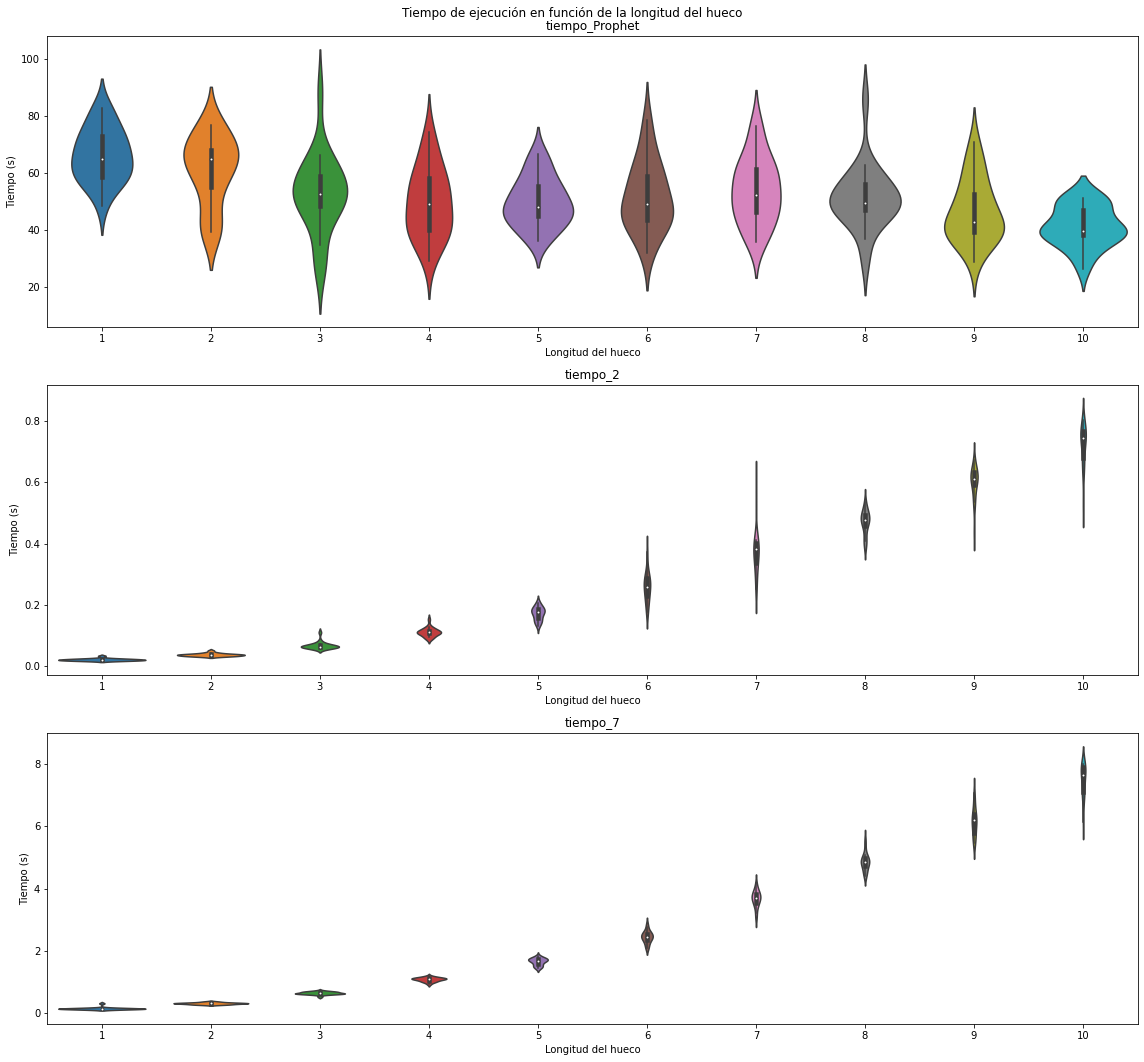

In [29]:

datos_inicio.to_csv('./experimento_final_completo.csv', index=False)


fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(16,15) )

for i in range(3):
    sns.violinplot(data=datos_inicio, x='tipo' , y=datos_inicio.columns[i*4+1], ax = axes[i])
    axes[i].title.set_text(datos_inicio.columns[i*4+1])
    axes[i].set_xlabel('Longitud del hueco')
    axes[i].set_ylabel('Tiempo (s)')



plt.suptitle("Tiempo de ejecución en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_final2_variacion_tiempos.png')


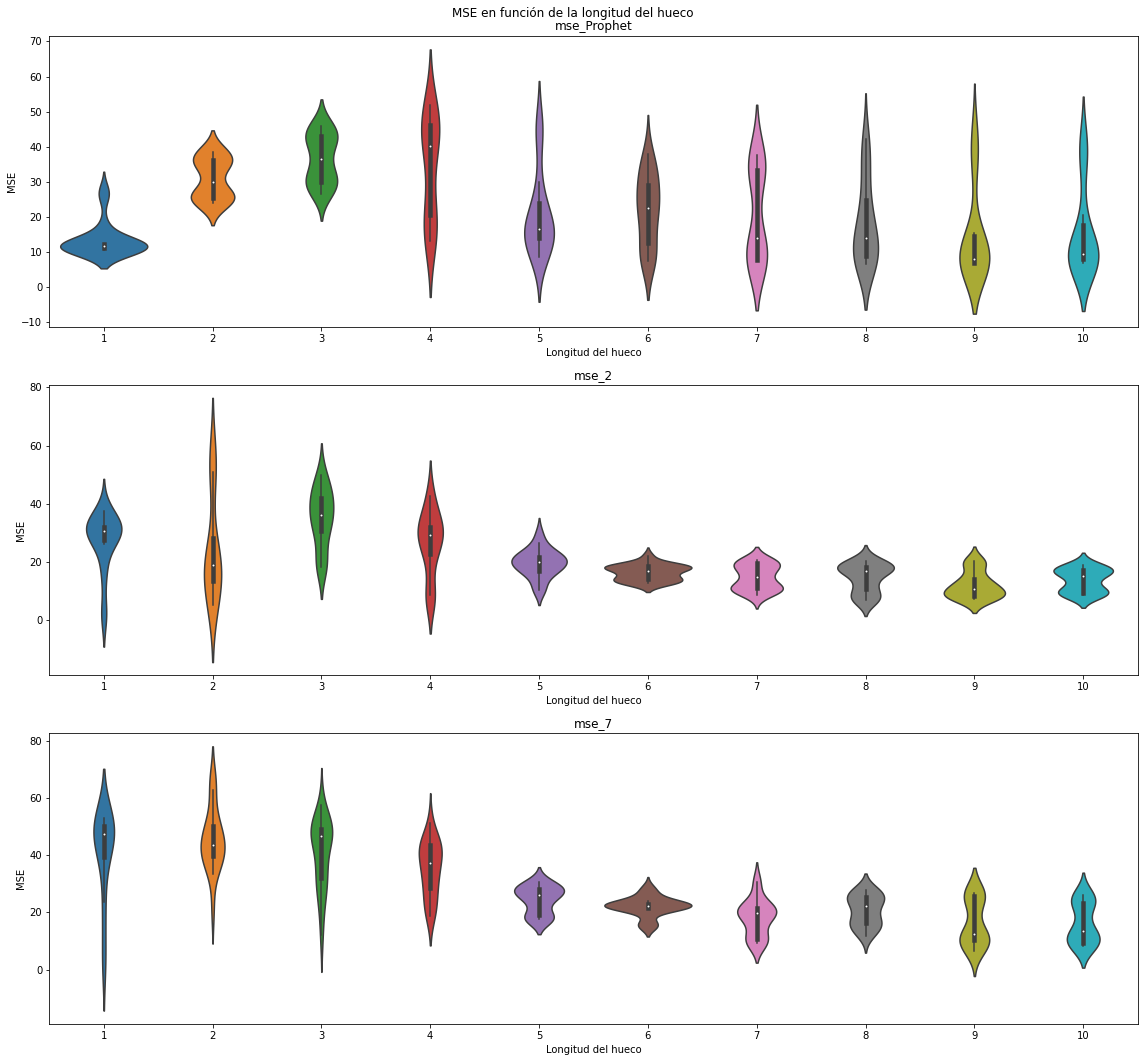

In [30]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(16,15) )



for i in range(3):
    sns.violinplot(data=datos_inicio, x='tipo' , y=datos_inicio.columns[i*4+2], ax = axes[i])
    axes[i].title.set_text(datos_inicio.columns[i*4+2])
    axes[i].set_xlabel('Longitud del hueco')
    axes[i].set_ylabel('MSE')


plt.suptitle("MSE en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_final2_variacion_mse.png')

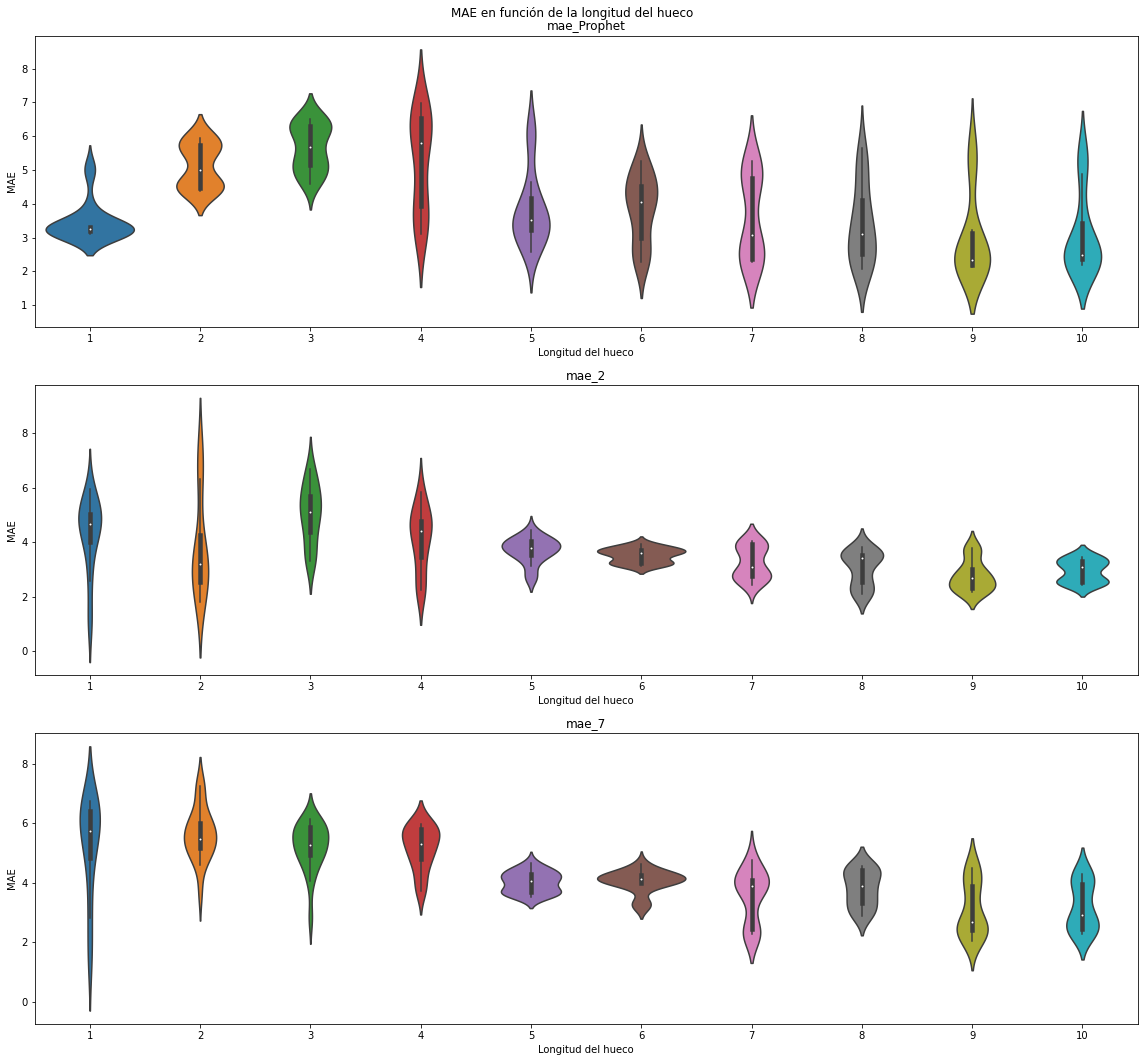

In [31]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(16,15) )



for i in range(3):
    sns.violinplot(data=datos_inicio, x='tipo' , y=datos_inicio.columns[i*4+3], ax = axes[i])
    axes[i].title.set_text(datos_inicio.columns[i*4+3])
    axes[i].set_xlabel('Longitud del hueco')
    axes[i].set_ylabel('MAE')


plt.suptitle("MAE en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_final2_variacion_mae.png')

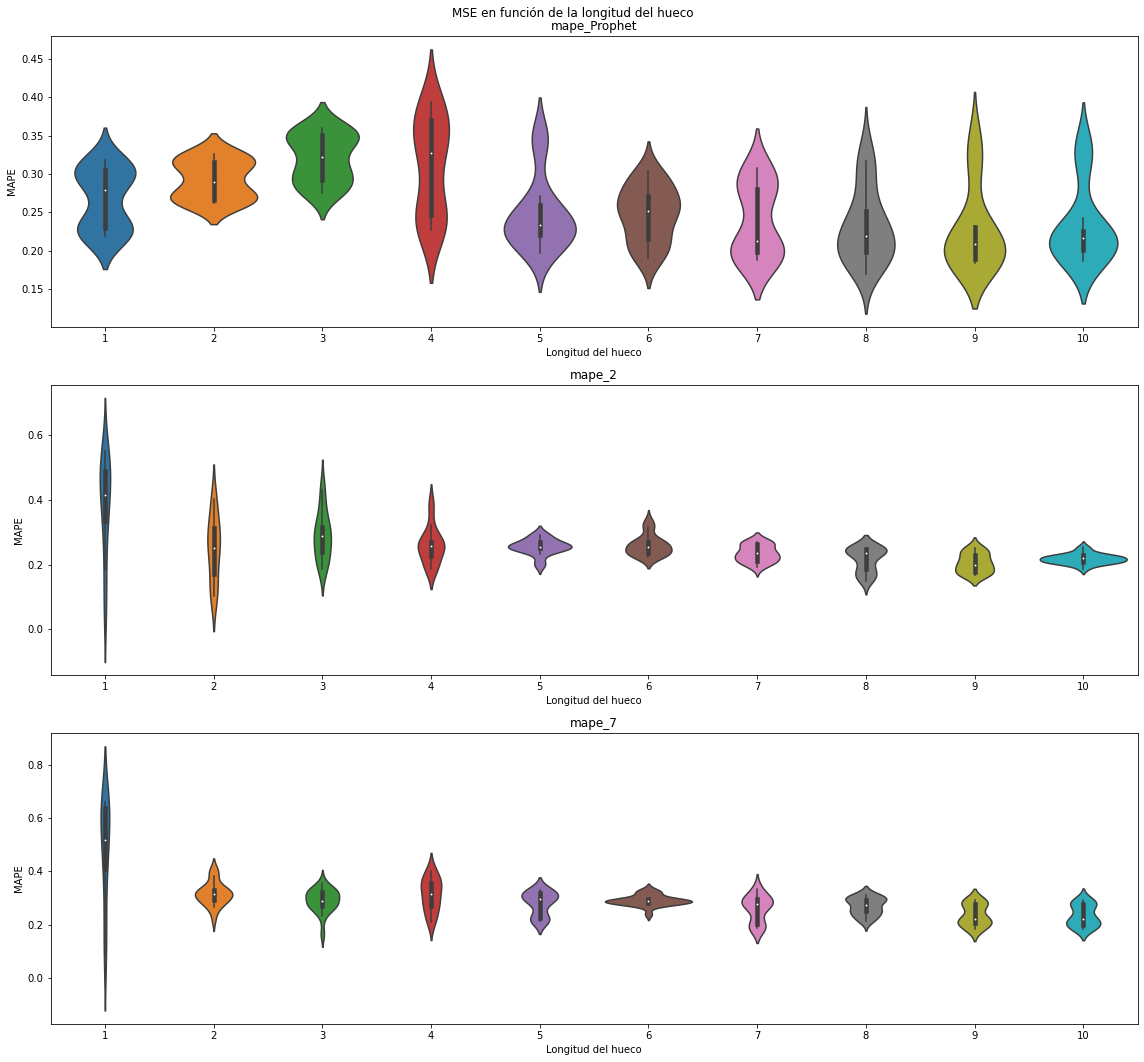

In [32]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(16,15) )



for i in range(3):
    sns.violinplot(data=datos_inicio, x='tipo' , y=datos_inicio.columns[i*4+4], ax = axes[i])
    axes[i].title.set_text(datos_inicio.columns[i*4+4])
    axes[i].set_xlabel('Longitud del hueco')
    axes[i].set_ylabel('MAPE')


plt.suptitle("MSE en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_final2_variacion_mape.png')

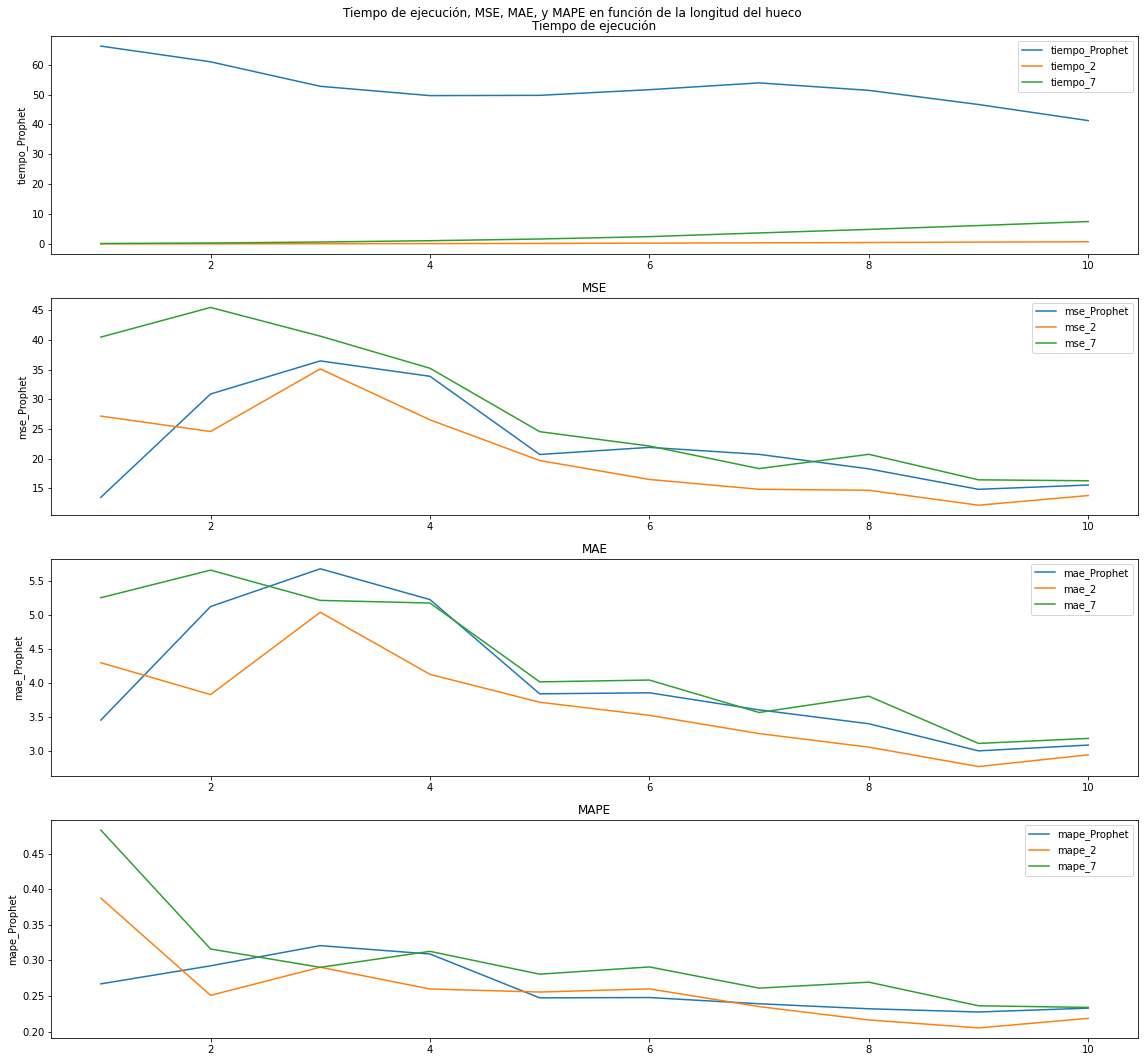

In [33]:
import seaborn as sns
x=np.arange(1,11)
fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(16,15) )

for i in range(3):
    sns.lineplot(x=x, y=datos_inicio.groupby('tipo').mean()[datos_inicio.columns[i*4+1]], label=datos_inicio.columns[i*4+1], ax = axes[0])

for i in range(3):
    sns.lineplot(x=x, y=datos_inicio.groupby('tipo').mean()[datos_inicio.columns[i*4+2]], label=datos_inicio.columns[i*4+2], ax = axes[1])

for i in range(3):
    sns.lineplot(x=x, y=datos_inicio.groupby('tipo').mean()[datos_inicio.columns[i*4+3]], label=datos_inicio.columns[i*4+3], ax = axes[2])

for i in range(3):
    sns.lineplot(x=x, y=datos_inicio.groupby('tipo').mean()[datos_inicio.columns[i*4+4]], label=datos_inicio.columns[i*4+4], ax = axes[3])


axes[0].title.set_text('Tiempo de ejecución')
axes[1].title.set_text('MSE')
axes[2].title.set_text('MAE')
axes[3].title.set_text('MAPE')

plt.suptitle("Tiempo de ejecución, MSE, MAE, y MAPE en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_final2_detail.png')

In [34]:
b=[np.arange(1,21)]*10
b=[item for sublist in b for item in sublist]


In [35]:
datos_inicio['num_ejecucion']=b

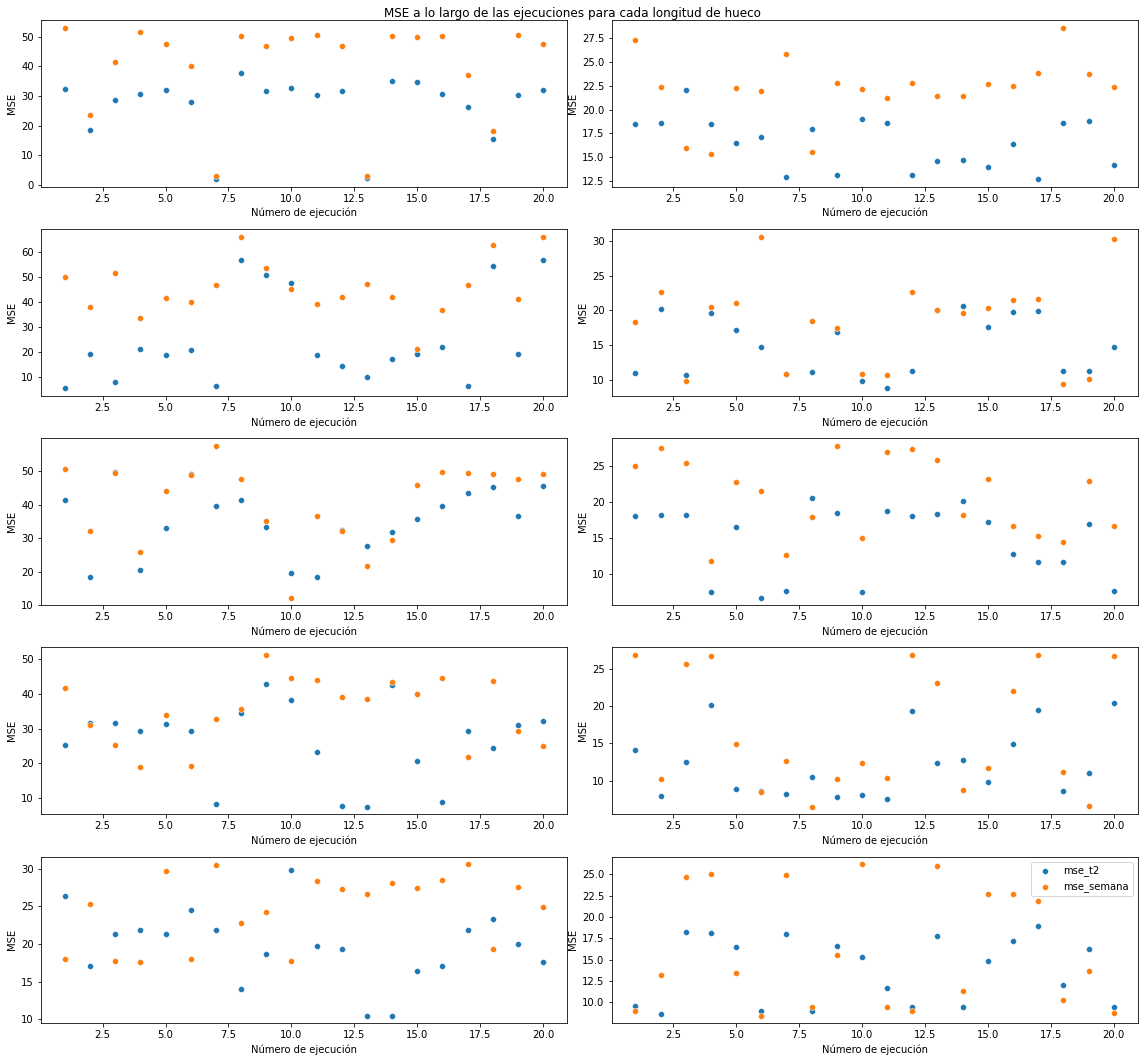

In [36]:
import seaborn as sns
x=np.arange(1,11)
fig, axes = plt.subplots(nrows=5,ncols=2, figsize=(16,15) )


for i in range(10):
    sns.scatterplot(x='num_ejecucion', y='mse_2', data=datos_inicio[datos_inicio['tipo']==i+1], ax = axes[i%5][int(i/5)])
    sns.scatterplot(x='num_ejecucion', y='mse_7', data=datos_inicio[datos_inicio['tipo']==i+1], ax = axes[i%5][int(i/5)])
    axes[i%5][int(i/5)].set_xlabel('Número de ejecución')
    axes[i%5][int(i/5)].set_ylabel('MSE')

plt.legend(['mse_t2', 'mse_semana'])
plt.suptitle("MSE a lo largo de las ejecuciones para cada longitud de hueco")
plt.tight_layout()
plt.savefig('./scatter_final2.png')